<a href="https://colab.research.google.com/github/Elghandour-eng/Arabic_Image_Captioning/blob/main/Image_captioning_decoder%26encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`Image Captioning`**

### 1- Importing Libraries

In [1]:
!pip install googletrans==3.1.0a0
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd     # for data manipulation and analysis
import numpy as np      # for scientific computing
import matplotlib.pyplot as plt     # for plotting graphs
import seaborn as sns     # for plotting graphs
import tensorflow as tf   #modeling
from tensorflow import keras  # modeling
import os # for managing directories and paths
import re # import regex
from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # import pad_sequences
import time # Time
import googletrans  
from gtts import gTTS

### 2- Load Data

In [3]:
captions_folders = '/flicker8k_text'

if not os.path.exists(os.path.abspath('.') + captions_folders):
    caption_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                            cache_subdir=os.path.abspath('.'), 
                                            origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                            extract = True)
    os.remove(caption_zip) #remove the zipfile since we have extracted it
    
image_folders = '/flicker8k_Dataset'

if not os.path.exists(os.path.abspath('.') + image_folders):
    image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',
                                            cache_subdir=os.path.abspath('.'), 
                                            origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                            extract = True)
    os.remove(image_zip) #remove the zipfile since we have extracted it

else:
    path = os.path.abspath('.') + image_folders
    

2340801/2340801 [==============================] - 0s 0us/step


In [4]:
class LoadData:
    def load_text_doc(self ,file_path):
        with open(file_path) as f:
            captions = f.read()
            return captions
    
    def image_caption_dict(self ,text):
        caption_mappings = {}
        lines = text.split('\n')
        
        for line in lines :
            line_split = line.split('\t') # split the line by tab delimiter (Tokenize)
            if len(line_split) < 2: # skip the lines with less than 2 elements
                continue
            else :
                image_meta , caption = line_split
            raw_image_name , caption_number = image_meta.split('#') # split the image name and caption number
            image_name = raw_image_name.split('.')[0] # remove the .jpg extension from the image name
            
            if (int(caption_number) == 0):
                caption_mappings[image_name] = [caption] # create a new list for the image name
            else :
                caption_mappings[image_name].append(caption)
            
        return caption_mappings
    
    def train_img_names(self ,file_path):
        data = []
        with open(file_path) as f:
            text = f.read()
            lines = text.split('\n')
            
            for line in lines :
                if len(line) < 1:
                    continue
                image_name = line.split('.')[0]
                data.append(image_name)
        return (data) # return a list of image names

In [5]:
data_loader = LoadData()

dataset_dir = '/content/Flicker8k_Dataset'
captions_file_path = '/content/Flickr8k.token.txt'
train_file_path = '/content/Flickr_8k.trainImages.txt'


captions_txt = data_loader.load_text_doc(captions_file_path)
image_caption_dict = data_loader.image_caption_dict(captions_txt)
train_img_names = data_loader.train_img_names(train_file_path)

### 3- Data Preprocessing

In [6]:
class PreProcessimages :
    def load_image(self, path):
        image = tf.io.read_file(path) # read the image from the path
        image = tf.image.decode_jpeg(image, channels=3) # decode the image to a tensor
        image = tf.image.resize(image, (299, 299)) # resize the image to the required size
        image = tf.keras.applications.inception_v3.preprocess_input(image) # preprocess the image
        
        return image, path
    
    def apply_inception_v3(self, ds_dir , train_img_names):
        
        from tqdm import tqdm # tqdm for progress bar
        
        model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        new_input = model.input # get the input layer
        hidden_layer = model.layers[-1].output # get the output layer
        image_features_extract_model = tf.keras.Model(new_input, hidden_layer) # create a new model
        trainig_img_path = [ ds_dir + '/'+ img_name + '.jpg' for img_name in train_img_names] # create a list of image paths
        encoded_training_data = sorted(set(trainig_img_path)) # remove duplicates
        img_ds = tf.data.Dataset.from_tensor_slices(encoded_training_data) # create a dataset from the list of image paths
        img_ds = img_ds.map(self.load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(14) # load the images in batches
        
        
        for img, path in tqdm(img_ds):
            batch_features = image_features_extract_model(img)
            batch_features = tf.reshape(batch_features, 
                                        (batch_features.shape[0], -1, batch_features.shape[3])) # reshape the features to (batch_size, 64, 2048)
        
            for bf, p in zip(batch_features, path):
                path_of_feature = p.numpy().decode("utf-8")
                np.save(path_of_feature, bf.numpy()) # save the features to a file
                
    

In [7]:
img_preprocess = PreProcessimages()
img_preprocess.apply_inception_v3(dataset_dir , train_img_names)

100%|██████████| 429/429 [02:21<00:00,  3.02it/s]


In [8]:
class PrepocessCaptions:
    
    def clean_captions_text(self ,parsed_img_captions_dict):
        
        for key , captions_text in parsed_img_captions_dict.items():
            for i ,caption in enumerate(captions_text):
                caption_nopunct = re.sub(r'[^a-zA-z0-9]','',caption.lower()) # remove punctuations
                clean_words = [word for word in caption_nopunct.split() if ((len(word)>1) and (word.isalpha()))] # remove single letter words
    
    
    def add_token(self, captions):
        for i, caption in enumerate(captions):
            captions[i] = 'startseq ' + caption + ' endseq'
        return (captions)
    
    
    def img_subset_data_dict(self, img_dict, img_names):
        data_dict = { img_name : self.add_token(captions) for img_name, captions
                     in img_dict.items() if img_name in img_names}
        return (data_dict)
    
    
    def flat_caps(self, data_dict):
       return { caption for key, captions in data_dict.items() for caption in captions}
   
   
    def caps_max_word_len(self, caps):
        return max(len(caption.split()) for caption in caps)
    
    
    def apply_tokenizer(self, data_dict):
        caps = self.flat_caps(data_dict)
        max_cap_len = self.caps_max_word_len(caps)
        
        
        tokenzier = Tokenizer()
        tokenzier.fit_on_texts(caps)
        vocab_size = len(tokenzier.word_index) + 1
        
        return (tokenzier , vocab_size , max_cap_len)
    
    
    def pad_text(self, parsed_img_caps_dict, max_length):
        paddeed_cap_text = pad_sequences([parsed_img_caps_dict], maxlen=max_length, padding='post')[0]
        
        return (paddeed_cap_text)
    
    def data_prep(self, data_dict, img_dir ,tokenizer, max_len, vocab_size):
        X, y = list(), list()
        
        for image_name, captions in data_dict.items():
            iamge_name = img_dir + image_name + '.jpg' 
            for caption in captions:
                word_idxs = tokenizer.texts_to_sequences([caption])[0]
                pad_idxs = self.pad_text(word_idxs, max_len)
                X.append(image_name)
                y.append(pad_idxs)
                
        return X, y 

In [9]:
caps_preprocess = PrepocessCaptions() # create an instance of the class

caps_preprocess.clean_captions_text(image_caption_dict)  # clean the captions text
data_dict_train = caps_preprocess.img_subset_data_dict(image_caption_dict, train_img_names) # create a dictionary of image names and their captions
tokenizer, vocab_size, max_length = caps_preprocess.apply_tokenizer(data_dict_train) # apply the tokenizer on the training data
train_X, train_y = caps_preprocess.data_prep(data_dict_train, dataset_dir, tokenizer, max_length, vocab_size) # prepare the training data

In [10]:
Batch_Size = 64
Buffer_Size = 1000
def npy_loader(img_name, caption):
    img_tensor = np.load("/content/Flicker8k_Dataset/"+img_name.decode('utf-8')+'.jpg'+'.npy')
    return img_tensor, caption

def prepare_tf_dataset(Buffer_size, Batch_size, X_train, y_train):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                npy_loader, [item1, item2], [tf.float32, tf.int32]),
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(Buffer_size).batch(Batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

### 4- Modeling

In [11]:
class ModelAttention(keras.Model):
    def __init__(self, units):
        super(ModelAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        hidden_along_time_axis = tf.expand_dims(hidden, 1)
        attention_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_along_time_axis)))
        score = self.V(attention_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        
        return context_vector, attention_weights


#### Encoder 

In [12]:
class CnnEncoder(keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(CnnEncoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        
        return x

#### Decoder

In [13]:
class RnnDecoder(keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RnnDecoder, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = ModelAttention(self.units) 
        
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
            
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
            
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
            
        x = self.fc2(x)
            
        return x, state, attention_weights
        
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### 5- Training

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [15]:
embedding_dim = 256
units = 512
encoder = CnnEncoder(embedding_dim, units, vocab_size)
decoder = RnnDecoder(embedding_dim, units, vocab_size)

checkpoint_path = './checkpoints/train'
checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=5)
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [16]:
losses = []
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [17]:
import time
EPOCHS = 1
start_epoch = 0
dataset = prepare_tf_dataset(Buffer_Size, Batch_Size ,train_X, train_y)

num_steps = len(train_X) // Batch_Size

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_training_loss = 0
    for (batch, (img_tensor, target_caps)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target_caps)
        total_training_loss += t_loss
        
        if batch % 5 == 0:
            ckpt_manager.save()
        
        if batch % 100 == 0:
            avg_batch_loss = batch_loss.numpy() / int(target_caps.shape[1])
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, avg_batch_loss))
        
    losses.append(total_training_loss / num_steps)
    
    print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_training_loss / num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.2719
Epoch 1 Batch 100 Loss 1.1706
Epoch 1 Batch 200 Loss 1.0036
Epoch 1 Batch 300 Loss 0.9910
Epoch 1 Batch 400 Loss 1.0391
Epoch 1 Loss 1.062802
Time taken for 1 epoch 285.52924513816833 sec



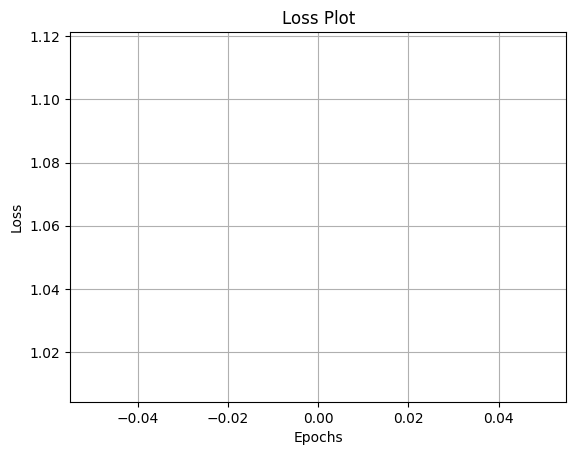

In [27]:
plt.plot(losses) # plotting by columns
plt.xlabel('Epochs') # naming the x axis
plt.ylabel('Loss') # naming the y axis
plt.title('Loss Plot') # giving a title to my graph
plt.grid() # show a grid
plt.show() # function to show the plot

In [18]:
from PIL import Image

def features_extrector(temp_input):
        model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        #temp_input = model.input # get the input layer
        hidden_layer = model(temp_input) # get the output layer
        #image_features_extract_model = tf.keras.Model(temp_input, hidden_layer) # create a new model
        return hidden_layer

def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(img_preprocess.load_image(image)[0], 0)
    img_tensor_val = features_extrector(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    
    
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == 'endseq':
            return result
        
        dec_input = tf.expand_dims([predicted_id], 0)
    return result

def predict(image_url, random_name):
    image_extension = image_url[-4:]
    image_path = tf.keras.utils.get_file('image'+random_name + image_extension, origin=image_url)
    result = evaluate(image_path)
    print('Prediction Caption:', ' '.join(result))
    display(Image.open(image_path))
    return result 

### 6- Model Prediction

Prediction Caption: two dogs terriers a dog 's fenced field endseq


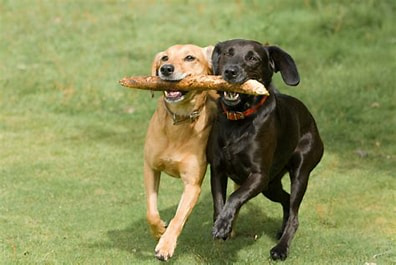

In [19]:
img_url = 'https://th.bing.com/th?id=OIP.eMgWAoPsuhZUcvcxuV48nAHaE9&w=305&h=204&c=8&rs=1&qlt=90&o=6&dpr=1.3&pid=3.1&rm=2'
english_text = predict(img_url, '1')


### 7- Translate Text

In [20]:
english_text = ' '.join(english_text)

In [21]:
english_text.replace("endseq"," ")
english_text.replace("startseq"," ")

"two dogs terriers a dog 's fenced field endseq"

In [24]:
from googletrans import Translator
translator = Translator()
ar = translator.translate(english_text, dest='ar')
ar.text

'كلاب كلاب ، حقل مسيج للكلب'

In [25]:
import IPython.display as ipd

tts = gTTS(ar.text, lang='ar')
tts.save('test.mp3')
audio_path="test.mp3"

ipd.Audio(audio_path, autoplay=True)

# `Thank You`